# Regression task: the time interval between two consecutive visits for the same patient ~ ICD diagnosis code

## Prepare the dataset

In [1]:
""" 
Patient ID -> admission ID
"""

' \nPatient ID -> admission ID\n'

In [2]:
import sys
sys.path.append("/home/wanxinli/deep_patient/")

from datetime import datetime
from mimic_common import *
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import gaussian_process



/home/wanxinli/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
output_dir = os.path.join(os.path.expanduser("~"), f"deep_patient/outputs/mimic")
print(f"Will save outputs to {output_dir}")
data_dir = os.path.join(os.path.expanduser("~"), f"deep_patient/mimic_exp/mimiciii")
print(f"Will read data from {data_dir}")

Will save outputs to /home/wanxinli/deep_patient/outputs/mimic
Will read data from /home/wanxinli/deep_patient/mimic_exp/mimiciii


In [4]:
admission_file = os.path.join(data_dir, "ADMISSIONS.csv")
diagnosis_file = os.path.join(data_dir, "DIAGNOSES_ICD.csv")
patient_file = os.path.join(data_dir, "PATIENTS.csv")

In [5]:
pid_adms, pid_gender, adm_date, admid_codes, pid_visits = build_maps(admission_file, diagnosis_file, patient_file)


In [6]:
# print(pid_visits)

In [7]:
# construct codes (ICD codes for the first visits), and durations (time interval until the next visit)

codes = []
durations = []
genders = []
for pid, visits in pid_visits.items():
    for i, cur_visit in enumerate(visits):
        if i == len(visits)-1: # stop on the last element
            break 
        next_visit = visits[i+1]
        # print(next_visit)
        cur_codes = cur_visit[1]
        # print(codes)
        duration = (next_visit[0]-cur_visit[0]).total_seconds()
        codes.append(cur_codes)
        durations.append(duration)
        genders.append(pid_gender[pid])


cons_visits_df = pd.DataFrame(columns=['gender', 'duration', 'ICD codes'])
cons_visits_df['gender'] = genders
cons_visits_df['duration'] = durations
cons_visits_df['ICD codes'] = codes
cons_visits_df.to_csv(os.path.join(output_dir, "CONS_VISITS.csv"), index=False, header=True)

cons_visits_df

,gender,duration,ICD codes
0,M,130162740.0,"[41401, 4111, 4241, V4582, 2724, 4019, 60000, ..."
1,M,145197420.0,"[41071, 4280, 4254, 42731, 9971, 4260, 41401, ..."
2,M,1082040.0,"[41401, 4111, 496, 4019, 3051, 53081, 60000, V..."
3,M,94491660.0,"[99831, 99811, 41511, 4538, 99672, 496, 41401,..."
4,M,20640960.0,"[5715, 5722, 2867, 45620, 3453, 48241, 51881, ..."
...,...,...,...
12451,M,9735840.0,"[42731, 56211, V1051]"
12452,M,8103720.0,"[99859, 0389, 99592, 78552, 5849, 5990, 42830,..."
12453,F,2644440.0,"[4373, 4019, 2449, 59651, 49390, V1052]"
12454,F,1994400.0,"[5363, 5641]"


In [8]:
""" 
Outputs consecutive visit stats
"""
female_count = cons_visits_df.loc[(cons_visits_df['gender'] == 'F')].shape[0]
male_count = cons_visits_df.loc[(cons_visits_df['gender'] == 'M')].shape[0]
print("female count is:", female_count)
print("male count is:", male_count)

female count is: 5627
male count is: 6829


In [9]:
"""
Train deep patient model and generate representations for targets and sources
"""

def custom_train_reps(target_features, source_features, n_components, pca_explain=False):
    """ 
    Customized training algorithm for generating target representations and source representations

    :param bool pca_explain: print the explained variance of each components
    
    :returns: target representations, source representations
    """
    source_pca = PCA(n_components=n_components)
    target_pca = PCA(n_components=n_components)
    target_reps = target_pca.fit_transform(target_features)
    source_reps = source_pca.fit_transform(source_features)

    if pca_explain:
        source_exp_var = source_pca.explained_variance_ratio_
        source_cum_sum_var = np.cumsum(source_exp_var)
        target_exp_var = target_pca.explained_variance_ratio_
        target_cum_sum_var = np.cumsum(target_exp_var)
        print("Cummulative variance explained by the source PCA is:", source_cum_sum_var[-1])
        print("Cummulative variance explained by the target PCA is:", target_cum_sum_var[-1])

    return target_reps, source_reps

In [12]:
n_components = 50
model_func = linear_model.PoissonRegressor
entire_proc_cts(n_components, cons_visits_df, custom_train_reps, model_func, male_count = 120, female_count = 100, pca_explain=True)

Cummulative variance explained by the source PCA is: 0.9605126794864611
Cummulative variance explained by the target PCA is: 0.9154070627730042


/home/wanxinli/.local/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


(9398344.86362918,
 16237261.340613468,
 171307787.5827491,
 583587848.7024859,
 37947299.79509404,
 61025792.05759225)

In [11]:
model_func = linear_model.LinearRegression
entire_proc_cts(n_components, cons_visits_df, custom_train_reps, model_func, male_count = 120, female_count = 100, pca_explain=False)

(32398207.2632488,
 46705008.66182081,
 45610881.770895936,
 64092019.82989011,
 40707236.717793494,
 59716592.300502874)

In [12]:
""" 
Run multiple iterations using Poisson regression
"""

score_path = os.path.join(output_dir, "exp5_poisson_score_"+str(n_components)+".csv")
male_count = 120
female_count = 100

multi_proc_cts(score_path, n_components, cons_visits_df, custom_train_reps, \
    male_count, female_count, model_func = linear_model.PoissonRegressor, iteration=100)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 29


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 68
iteration: 69
iteration: 70
iteration: 71
iteration: 72
iteration: 73
iteration: 74
iteration: 75
iteration: 76


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 77


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 78
iteration: 79
iteration: 80


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 81
iteration: 82
iteration: 83
iteration: 84
iteration: 85
iteration: 86
iteration: 87
iteration: 88


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 89
iteration: 90
iteration: 91
iteration: 92


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 93


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 94


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 95
iteration: 96
iteration: 97
iteration: 98
iteration: 99


array([[2.03930584e+07, 3.26081471e+07, 2.26411384e+08, 1.18100149e+09,
        4.03486435e+07, 6.16645479e+07],
       [2.23127847e+07, 3.49039473e+07, 4.80133703e+08, 4.25355858e+09,
        3.91637917e+07, 6.24070305e+07],
       [2.15351876e+07, 3.37615303e+07, 2.20940868e+08, 1.25052971e+09,
        3.86528913e+07, 6.04361994e+07],
       [2.13381399e+07, 3.41823901e+07, 6.11341936e+08, 5.30945793e+09,
        3.65243372e+07, 6.01811520e+07],
       [2.05269457e+07, 3.29557624e+07, 1.67303851e+08, 6.50044623e+08,
        3.88215826e+07, 6.10291069e+07],
       [2.04493510e+07, 3.28928000e+07, 3.37714583e+08, 2.03698366e+09,
        3.79462196e+07, 6.07975509e+07],
       [2.12251553e+07, 3.35056772e+07, 2.41232731e+08, 1.60865468e+09,
        4.00873282e+07, 6.33821388e+07],
       [2.04990222e+07, 3.22648095e+07, 3.09646164e+08, 1.80313288e+09,
        3.92861824e+07, 6.34995420e+07],
       [2.14422132e+07, 3.34682645e+07, 3.32620668e+08, 2.43153569e+09,
        3.92619444e+07, 

In [13]:
# score_path = os.path.join(output_dir, "exp5_poisson_score_"+str(n_components)+".csv")

# save_path = "../../outputs/mimic/exp5_poisson_res.png"

# box_plot_cts_short(score_path, save_path=save_path)

In [11]:
""" 
Run multiple iterations using Linear regression
"""

score_path = os.path.join(output_dir, "exp5_linear_score_"+str(n_components)+".csv")
multi_proc_cts(score_path, n_components, cons_visits_df, custom_train_reps, \
    male_count, female_count, model_func = linear_model.LinearRegression, iteration=100)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

array([[36463402.36558644, 52521505.04997672, 37463647.13915147,
        53148427.71622931, 37033523.40415076, 53023410.05728646],
       [36511493.48537087, 52564063.3494779 , 37514981.36606564,
        53187334.71223929, 37079244.87397592, 53025458.15990821],
       [36499325.84728251, 52524070.23318066, 37423089.75765695,
        53090308.07773064, 37014584.13938624, 53015072.11459717],
       [36496527.06762452, 52536116.60809615, 37480157.85042676,
        53121801.4984943 , 37175533.28779148, 53108874.0402846 ],
       [36492225.88572169, 52597466.25463954, 37312471.70664828,
        52945350.46384124, 36964875.19382763, 53017835.56764922],
       [36472742.07819061, 52528515.12147976, 37327920.07312699,
        53047370.77831607, 36956371.40699937, 52992818.71871962],
       [36508995.78989878, 52538896.23810674, 37492271.10132203,
        53182247.86851934, 37182453.84288353, 53142670.1382173 ],
       [36508176.34669128, 52548274.65578027, 37349497.89737742,
        53091481.6

In [48]:
# score_path = os.path.join(output_dir, "exp5_linear_score.csv")
# save_path = "../../outputs/mimic/exp5_linear_res.png"

# box_plot_cts_short(score_path, save_path=save_path)

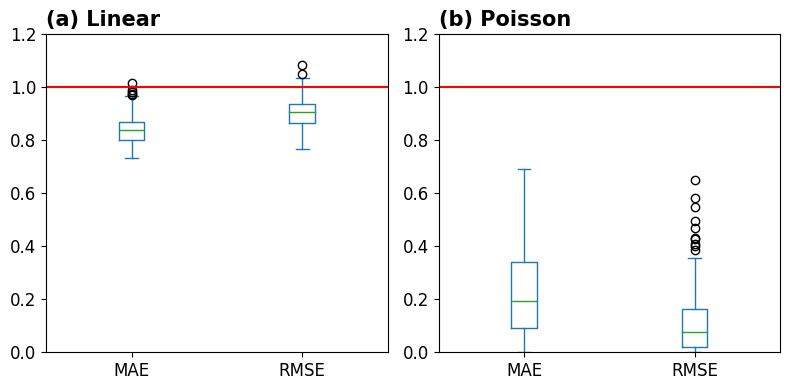

In [49]:
def special_div(x, y):
    """ 
    Special division operation
    """
    if y == 0:
        y = 1e-5
    return x/y

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(4)
fig.set_figwidth(8)
title_size = 15
text_size = 12

# plt.subplot(1,2,1)
score_path = os.path.join(output_dir, "exp5_linear_score_"+str(n_components)+".csv")

scores_df = pd.read_csv(score_path, index_col=None, header=0)

source_mae = scores_df['source_mae']
source_rmse = scores_df['source_rmse']

trans_source_mae = scores_df['trans_source_mae']
trans_source_rmse = scores_df['trans_source_rmse']

# transported source to source mae
trans_source_source_mae = [special_div(i, j) for i, j in zip(trans_source_mae, source_mae)]

# transported source to source rmse
trans_source_source_rmse = [special_div(i, j) for i, j in zip(trans_source_rmse, source_rmse)]


# Pandas dataframe
data = pd.DataFrame({
    'MAE': trans_source_source_mae,
    'RMSE': trans_source_source_rmse
})

# Plot the dataframe
ax = data[['MAE', 'RMSE']].plot(kind='box', ax=axes[0])

# Plot the baseline
ax.axhline(y = 1, color = 'r', linestyle = '-')

ax.tick_params(labelsize=text_size)
ax.set_ylim(0, 1.2)
ax.set_title("(a) Linear", fontweight='bold', loc='left', fontsize=title_size)

######################################################

score_path = os.path.join(output_dir, "exp5_poisson_score_"+str(n_components)+".csv")

scores_df = pd.read_csv(score_path, index_col=None, header=0)

source_mae = scores_df['source_mae']
source_rmse = scores_df['source_rmse']

trans_source_mae = scores_df['trans_source_mae']
trans_source_rmse = scores_df['trans_source_rmse']

# transported source to source mae
trans_source_source_mae = [special_div(i, j) for i, j in zip(trans_source_mae, source_mae)]

# transported source to source rmse
trans_source_source_rmse = [special_div(i, j) for i, j in zip(trans_source_rmse, source_rmse)]


# Pandas dataframe
data = pd.DataFrame({
    'MAE': trans_source_source_mae,
    'RMSE': trans_source_source_rmse
})

# Plot the dataframe
ax = data[['MAE', 'RMSE']].plot(kind='box', ax=axes[1])

# Plot the baseline
ax.axhline(y = 1, color = 'r', linestyle = '-')

ax.tick_params(labelsize=text_size)
ax.set_ylim(0, 1.2)
plt.title("(b) Poisson", fontweight='bold', loc='left', fontsize=title_size)
plt.tight_layout()

save_path = os.path.join(output_dir, "exp5_res_"+str(n_components)+".pdf")
plt.savefig(save_path, bbox_inches='tight')
plt.show()

mae ratio using linear is: 0.9903310049165912
rmse ratio using linear is: 0.9984539540681625
mae ratio using poisson is: 0.11856040834155676
rmse ratio using poisson is: 0.028363503229174622
mae ratio to TCA using linear is: 0.7562143932170287
rmse ratio to TCA using linear is: 0.7880788590571721
mae ratio to TCA using poisson is: 0.793643437331604
rmse ratio to TCA using poisson is: 0.9123697910599158


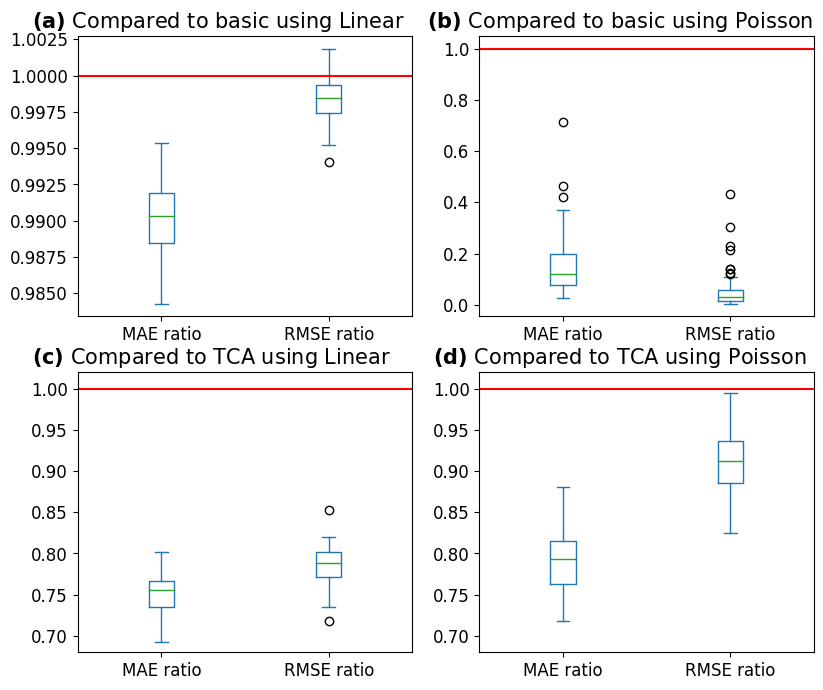

In [10]:
""" 
Combine plots for MIMIC experiment 5 together
"""
n_components = 50
def special_div(x, y):
    """ 
    Special division operation
    """
    if y == 0:
        y = 1e-5
    return x/y

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(9.5)
title_size = 15
text_size = 12
linear_score_path = os.path.join(output_dir, "exp5_linear_score_"+str(n_components)+".csv")

linear_scores_df = pd.read_csv(linear_score_path, index_col=None, header=0)

target_mae = linear_scores_df['target_mae']
target_rmse = linear_scores_df['target_rmse']

trans_target_mae = linear_scores_df['trans_target_mae']
trans_target_rmse = linear_scores_df['trans_target_rmse']

# transported source to source mae
trans_target_target_mae = [special_div(i, j) for i, j in zip(trans_target_mae, target_mae)]
print("mae ratio using linear is:", median(trans_target_target_mae))
# transported source to source rmse
trans_target_target_rmse = [special_div(i, j) for i, j in zip(trans_target_rmse, target_rmse)]
print("rmse ratio using linear is:", median(trans_target_target_rmse))


# Pandas dataframe
data = pd.DataFrame({
    'MAE ratio': trans_target_target_mae,
    'RMSE ratio': trans_target_target_rmse
})

# Plot the dataframe
ax = data[['MAE ratio', 'RMSE ratio']].plot(kind='box', ax=axes[0][0])

# Plot the baseline
ax.axhline(y = 1, color = 'r', linestyle = '-')

ax.tick_params(labelsize=text_size)
# ax.set_ylim(0, 1.005)
ax.set_title(r"$\bf{(a)}$ Compared to basic using Linear", x=0.42, fontsize=title_size)


######################################################

poisson_score_path = os.path.join(output_dir, "exp5_poisson_score_"+str(n_components)+".csv")

poisson_scores_df = pd.read_csv(poisson_score_path, index_col=None, header=0)

target_mae = poisson_scores_df['target_mae']
target_rmse = poisson_scores_df['target_rmse']

trans_target_mae = poisson_scores_df['trans_target_mae']
trans_target_rmse = poisson_scores_df['trans_target_rmse']

# transported source to source mae
trans_target_target_mae = [special_div(i, j) for i, j in zip(trans_target_mae, target_mae)]
print("mae ratio using poisson is:", median(trans_target_target_mae))

# transported source to source rmse
trans_target_target_rmse = [special_div(i, j) for i, j in zip(trans_target_rmse, target_rmse)]
print("rmse ratio using poisson is:", median(trans_target_target_rmse))


# Pandas dataframe
data = pd.DataFrame({
    'MAE ratio': trans_target_target_mae,
    'RMSE ratio': trans_target_target_rmse
})

# Plot the dataframe
ax = data[['MAE ratio', 'RMSE ratio']].plot(kind='box', ax=axes[0][1])

# Plot the baseline
ax.axhline(y = 1, color = 'r', linestyle = '-')

ax.tick_params(labelsize=text_size)
# ax.set_ylim(0, 1.005)
ax.set_title(r"$\bf{(b)}$ Compared to basic using Poisson", x=0.42, fontsize=title_size)

#####################################################
tca_linear_score_path = os.path.join(output_dir, "exp5_tca_linear_score.csv")

tca_linear_scores_df = pd.read_csv(tca_linear_score_path, index_col=None, header=0)

ot_target_mae = linear_scores_df['trans_target_mae']
ot_target_rmse = linear_scores_df['trans_target_rmse']

tca_target_mae = tca_linear_scores_df['trans_target_mae']
tca_target_rmse = tca_linear_scores_df['trans_target_rmse']

# transported source to source mae
trans_target_target_mae = [special_div(i, j) for i, j in zip(ot_target_mae, tca_target_mae)]
print("mae ratio to TCA using linear is:", median(trans_target_target_mae))

# transported source to source rmse
trans_target_target_rmse = [special_div(i, j) for i, j in zip(ot_target_rmse, tca_target_rmse)]
print("rmse ratio to TCA using linear is:", median(trans_target_target_rmse))

# Pandas dataframe
data = pd.DataFrame({
    'MAE ratio': trans_target_target_mae,
    'RMSE ratio': trans_target_target_rmse
})

# Plot the dataframe
ax = data[['MAE ratio', 'RMSE ratio']].plot(kind='box', ax=axes[1][0])

# Plot the baseline
ax.axhline(y = 1, color = 'r', linestyle = '-')

ax.tick_params(labelsize=text_size)
ax.set_ylim(0.68, 1.02)
ax.set_title(r"$\bf{(c)}$ Compared to TCA using Linear", x=0.40, fontsize=title_size)


####################################################
tca_poisson_score_path = os.path.join(output_dir, "exp5_tca_poisson_score.csv")

tca_poisson_scores_df = pd.read_csv(tca_linear_score_path, index_col=None, header=0)

ot_target_mae = poisson_scores_df['trans_target_mae']
ot_target_rmse = poisson_scores_df['trans_target_rmse']

tca_target_mae = tca_poisson_scores_df['trans_target_mae']
tca_target_rmse = tca_poisson_scores_df['trans_target_rmse']

# transported source to source mae
trans_target_target_mae = [special_div(i, j) for i, j in zip(ot_target_mae, tca_target_mae)]
print("mae ratio to TCA using poisson is:", median(trans_target_target_mae))

# transported source to source rmse
trans_target_target_rmse = [special_div(i, j) for i, j in zip(ot_target_rmse, tca_target_rmse)]
print("rmse ratio to TCA using poisson is:", median(trans_target_target_rmse))

# Pandas dataframe
data = pd.DataFrame({
    'MAE ratio': trans_target_target_mae,
    'RMSE ratio': trans_target_target_rmse
})

# Plot the dataframe
ax = data[['MAE ratio', 'RMSE ratio']].plot(kind='box', ax=axes[1][1])

# Plot the baseline
ax.axhline(y = 1, color = 'r', linestyle = '-')

ax.tick_params(labelsize=text_size)
ax.set_ylim(0.68, 1.02)
ax.set_title(r"$\bf{(d)}$ Compared to TCA using Poisson", x=0.42, fontsize=title_size)
save_path = os.path.join(output_dir, "exp5_res.pdf")
plt.savefig(save_path, bbox_inches='tight')